# OBIA Feature Extraction with Sentinel-2 Imagery


This notebook performs object-based feature extraction from Sentinel-2 imagery using the `nickyspatial` library.

Steps included:
1. Load Sentinel-2 bands (Red and NIR)
2. Compute NDVI
3. Segment the image using SLIC
4. Convert segments to vector objects
5. Extract object statistics (NDVI, area, shape metrics)
6. Compute global texture (GLCM contrast)
7. Save and visualize the results
    

In [2]:

import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
# from skimage.feature import greycomatrix, greycoprops

import nickyspatial
from nickyspatial import SlicSegmentation, attach_basic_stats, attach_shape_metrics, layer_to_vector


## Load Sentinel-2 Red and NIR bands from multiband TIFF

In [ ]:
# with rasterio.open(multiband_path) as src:
#     print(f"Number of bands: {src.count}")
#     for i in range(1, src.count + 1):
#         print(f"Band {i} - dtype: {src.dtypes[i-1]}, description: {src.descriptions[i-1]}")

Number of bands: 6
Band 1 - dtype: uint8, description: None
Band 2 - dtype: uint8, description: None
Band 3 - dtype: uint8, description: None
Band 4 - dtype: uint8, description: None
Band 5 - dtype: uint8, description: None
Band 6 - dtype: uint8, description: None


In [6]:

# Replace with your actual file path
multiband_path =  "../data/Sentinel2A_subset_bands_ToA_BGRNirSWIR1SWIR2.tif"

with rasterio.open(multiband_path) as src:
    print(f"Number of bands: {src.count}")
    red = src.read(3).astype("float32")  # Band 4: Red
    nir = src.read(4).astype("float32")  # Band 8: NIR
    transform = src.transform
    profile = src.profile


Number of bands: 6


## Compute NDVI

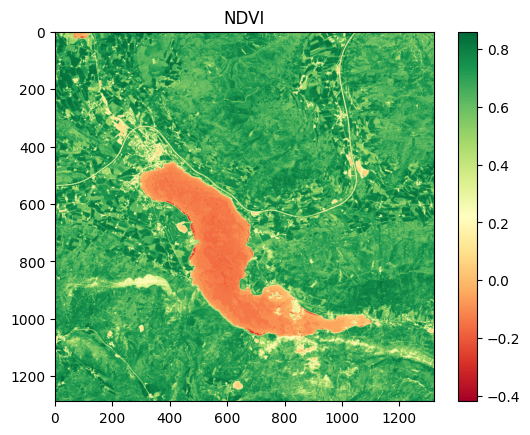

In [7]:

ndvi = (nir - red) / (nir + red)
ndvi = np.clip(ndvi, -1, 1)

plt.imshow(ndvi, cmap='RdYlGn')
plt.title("NDVI")
plt.colorbar()
plt.show()


## Apply SLIC Segmentation

In [11]:
dir(SlicSegmentation)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_calculate_statistics',
 '_create_segment_objects',
 'execute']

In [13]:

slic = SlicSegmentation()
segments = slic.execute(ndvi, transform=transform, crs=profile["crs"])

plt.imshow(segments, cmap='tab20')
plt.title("Segmented Image")
plt.colorbar()
plt.show()


ValueError: not enough values to unpack (expected 3, got 2)

## Convert Segments to Vector and Attach Statistics

In [ ]:

# Build the layer dictionary
layer = {'raster': ndvi, 'segments': segments, 'transform': transform}

# Convert to vector
gdf = layer_to_vector(layer)

# Attach mean NDVI per object
gdf = attach_basic_stats(gdf, ndvi, stat_name='mean_ndvi')

# Attach shape metrics (area, perimeter, compactness)
gdf = attach_shape_metrics(gdf)


## Compute Global GLCM Contrast (Optional)

In [ ]:

ndvi_int = ((ndvi + 1) * 127.5).astype('uint8')  # Scale NDVI to 0–255
glcm = greycomatrix(ndvi_int, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
contrast = greycoprops(glcm, 'contrast')[0, 0]

# Add global contrast value to each object (can be refined per object if needed)
gdf['glcm_contrast'] = contrast


## Save to GeoJSON

In [ ]:

gdf.to_file("obia_features.geojson", driver="GeoJSON")


## Visualize NDVI per Object

In [ ]:

gdf.plot(column='mean_ndvi', cmap='YlGn', legend=True)
plt.title("Mean NDVI per Object")
plt.show()
